# Generating biophysically detailed multi-compartmental models

This notebook provides a walkthrough on how to use ISF in order to generate biophysically detailed multi-comparmental models (MCM). To do this, you will need:

1. A neuron morphology in the `.hoc` format
2. Ion channel dynamics (`.mod` files).

ISF provides two ways of generating MCMs: 

1. A [Multi-Objective Evolutionary Algorithm (MOEA)](../../../biophysics_fitting/MOEA_EH_minimal/)
2. An [exploration algorithm](../../../biophysics_fitting/exploration_from_seedpoint/__init__.py). 

The former does not require any a priori assumptions on biophysical parameters to find a MCM, but fails to explore the full diversity of possible MCMs. The latter can explore the full diversity of possible biophysical models, but also requires a MCM as a seedpoint in order to start. If you need to generate models from scratch, we recommend using the MOEA algorithm to find at least a single model, and then using this as a seedpoint for the exploration algorithm.

In [ ]:
import Interface as I
from getting_started import getting_started_dir

example_data_dir = I.os.path.join(getting_started_dir, 'example_data', 'simulation_data', 'biophysics')
db = I.DataBase(example_data_dir)

## Multi-Objective Evolutionary Algorithm

This section will guide you through using ISF to create biophysically detailed MCM from scratch using a Multi-Objective Evolutionary Optimization algorithm (MOEA) called [BluePyOpt](https://github.com/BlueBrain/BluePyOpt). As an example, we will generate models for a Layer 5 Pyramidal Tract neuron (L5PT), whose biophysical mechanisms can be found in [`mechanisms.l5pt`](../../../mechanisms/l5pt/__init__.py).

Let's start by cerating a DataBase to save results in

In [ ]:
db_mooa = db.create_sub_db('MOEA')

Now, we need an initial guess to start our exploration with.

In [ ]:
from biophysics_fitting.hay_complete_default_setup import get_feasible_model_params

params = get_feasible_model_params().drop('x', axis=1)
params.index = 'ephys.' + params.index

In addition to the conductance of the ion channels, two important free parameters need to be added in order to find good MCMs for an L5PT:
- The spatial distribution of $SKv3.1$ channels along the apical dendrite. These are modeled here to slope off from the soma towards the end of the apical dendrite.
- The thickness of the apical dendrite. Why this is added as a free parameter is explained in [this auxiliary notebook](../auxiliary%20notebooks/A.1%20Morphology%20Reconstruction.ipynb)

In [ ]:
params = params.append(
    I.pd.DataFrame({
        'ephys.SKv3_1.apic.slope': {
            'min': -3,
            'max': 0
        },
        'ephys.SKv3_1.apic.offset': {
            'min': 0,
            'max': 1
        }
    }).T)
params = params.append(
    I.pd.DataFrame({
        'min': .333,
        'max': 3
    }, index=['scale_apical.scale']))


params = params.sort_index()
params

The MOEA algorithm does not expect a Simulator or Evaluator object as a direct input. Rather, it requires a DataBase object, where methods are saved that specify how to get these objects.

In [ ]:
from biophysics_fitting.L5tt_parameter_setup import get_L5tt_template_v2, get_Simulator, get_Evaluator, get_Combiner

def scale_apical(cell_param, params):
    assert(len(params) == 1)
    cell_param.cell_modify_functions.scale_apical.scale = params['scale']
    return cell_param

def get_fixed_params(db_setup):
    fixed_params = db_setup['fixed_params']
    fixed_params['morphology.filename'] = db_setup['morphology'].get_file(
        'hoc')
    return fixed_params

def get_Simulator(db_setup, step=False):
    fixed_params = db_setup['get_fixed_params'](db_setup)
    s = get_Simulator(
        I.pd.Series(fixed_params),
        step=step)
    s.setup.cell_param_generator = get_L5tt_template_v2
    s.setup.cell_param_modify_funs.append(
        ('scale_apical', scale_apical)
        )
    return s

def get_Evaluator(db_setup, step=False):
    return get_Evaluator(step=step)

def get_Combiner(db_setup, step=False):
    return get_Combiner(step=step)

In [ ]:
def set_up_db_for_MOEA(db, morphology_id='89', morphology="", step=False):
    """
    Set up a DataBase for MOEA.

    Args:
        - db: a DataBase object
        - morphology_id: name of the morphology
        - morphology: path to a .hoc morphology file
        - step: whether or not to perform step current injections

    Returns:
        data_base.DataBase: a database containing:
            - fixed_params
            - get_fixed_params
            - get_Simulator
            - get_Evaluator
            - get_Combiner
            - the morphology file
    """
    from data_base.IO.LoaderDumper import pandas_to_pickle, to_cloudpickle
    db.create_sub_mdb(morphology_id)

    db[morphology_id].create_managed_folder('morphology')
    I.shutil.copy(
        I.os.path.join(
            morphology
        ), db[morphology_id]['morphology'].join(
            morphology.split(I.os.sep)[-1]
        ))

    db[morphology_id]['fixed_params'] = {
        'BAC.hay_measure.recSite': 835,
        'BAC.stim.dist': 835,
        'bAP.hay_measure.recSite1': 835,
        'bAP.hay_measure.recSite2': 1015,
        'hot_zone.min_': 900,
        'hot_zone.max_': 1100,
        'morphology.filename': None
    }

    db[morphology_id]['get_fixed_params'] = get_fixed_params
    db[morphology_id].setitem('params', params, dumper=pandas_to_pickle)
    db[morphology_id].setitem('get_Simulator',
                      I.partial(get_Simulator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].setitem('get_Evaluator',
                      I.partial(get_Evaluator, step=step),
                      dumper=to_cloudpickle)
    db[morphology_id].setitem('get_Combiner',
                      I.partial(get_Combiner, step=step),
                      dumper=to_cloudpickle)

    return db

In [ ]:
set_up_db_for_MOEA(
    db_mooa,
    morphology_id="89",
    morphology=db['morphology'],
    step=False
    )

In [ ]:
from biophysics_fitting.optimizer import start_run

start_run(
    db['89'], 
    seed=42, 
    client=I.get_client(), 
    offspring_size=1000, 
    pop=None  # adapt this to the output population of the previous run to continue where you left off
    )

## Exploration from seedpoint

Given a biophysical model that performs well on all objectives, it is possible to continuously make variations on the biophysical parameters, while monitoring how well it performs on pre-defined benchmarks (in this case, the ones described above).

This is conveniently packaged in [`biophysics_fitting.exploration_from_seedpoint`](../../../biophysics_fitting/exploration_from_seedpoint/__init__.py).

> ℹ️ **If you don't have a seedpoint yet**, we recommend running a Multi-Objective Optimization Algorithm first, e.g. the evolutionary algorithm [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) (see [the section above](./1.3%20Generation.ipynb) for an example application of BluePyOpt to an L5PT).

In [ ]:
from biophysics_fitting.hay_complete_default_setup_python import get_Evaluator

evaluator = get_Evaluator(step=False)
simulator = db['89']['simulator']
biophysical_parameter_ranges = db['89']['params']
example_models = db['89']['example_models']
biophysical_parameter_names = [e for e in example_models.columns if "ephys" in e or e == "scale_apical.scale"]

In [ ]:
if not I.os.path.exists(I.os.path.join(db.basedir, 'RW_exploration_example')):
    db.create_managed_folder('RW_exploration_example')

[WARNING] isf_data_base: The database source folder has uncommitted changes!


In [ ]:
from biophysics_fitting.exploration_from_seedpoint.RW import RW
from biophysics_fitting.exploration_from_seedpoint.utils import evaluation_function_incremental_helper
from biophysics_fitting.hay_evaluation import hay_evaluate_bAP, hay_evaluate_BAC

evaluation_function = I.partial(
    evaluation_function_incremental_helper,
    s=simulator,
    e=evaluator,
    stim_order=['bAP', 'BAC']
)

rw = RW(
    param_ranges = biophysical_parameter_ranges,
    df_seeds = example_models[biophysical_parameter_names],
    evaluation_function = evaluation_function,
    MAIN_DIRECTORY = db['RW_exploration_example'],
    min_step_size = 0.02,
    max_step_size = 0.02,
    checkpoint_every = 10)

Let's run this for 60 seconds and see what happens. You can always restart the exploration and it will pick up from where it left off. Note that by default, it only writes out models every 10 models it has found. I fyou haven't found at least 10 models after $60$ seconds, you may want to increase computational power, or the `snooziness` parameter.

In [ ]:
snooziness = 60  # in seconds

from time import sleep
from threading import Thread
import multiprocessing

proc = multiprocessing.Process(
    target=rw.run_RW, 
    kwargs={
        'selected_seedpoint': 0,
        'particle_id': 0,
        'seed': 42  # for numpy random seed
    })
proc.start()
sleep(snooziness)
proc.terminate()  # sends a SIGTERM
proc.join()

35
My random number generator seed is 42
I am particle 0 and I write to /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/simulation_data/biophysics/RW_exploration_example/0/0
So far nothing simulated, start from seedpoint 0
evaluating stimulus bAP
evaluating stimulus BAC
all stimuli successful!
exploration loop
New loop. Current iteration 0
Get new position
Position within boundaries found, step size is 0.02 Tested  3 positions to find one inside the box.
evaluating stimulus bAP
evaluating stimulus BAC
all stimuli successful!
Inside the space? True
Moving current position to proposed position
distance to initial seed point (normalized): 0.02000000000000001
New loop. Current iteration 1
Get new position
Position within boundaries found, step size is 0.02 Tested  1 positions to find one inside the box.
evaluating stimulus bAP
evaluating stimulus BAC
all stimuli successful!
Inside the space? True
Moving current position to proposed position
d

In [ ]:
from biophysics_fitting.exploration_from_seedpoint.RW_analysis import Load

outdir = db['RW_exploration_example'].join('0')
l = Load(
    I.get_client(),
    outdir,
    n_particles = 1)

In [ ]:
explored_models = l.get_df().compute()
print("Explored {} new models".format(len(explored_models)))

Explored 21 new models


How much did the exploration actually explore? Let's plot out how much it deviated from it's starting point, relative to the total extent of parameter limits we allowed for

In [ ]:
def normalize(df, mn, mx):
    return (df - mn)/(mx-mn)
    
mn, mx = biophysical_parameter_ranges['min'], biophysical_parameter_ranges['max']
normalized_startpoint = normalize(example_models.iloc[0][biophysical_parameter_names], mn, mx)
normalized_explored_models = normalize(explored_models[biophysical_parameter_names], mn, mx)

# calc exploration relative to startpoint, in % of total allowed parameter limits
d = I.pd.concat([normalized_explored_models, I.pd.DataFrame(normalized_startpoint).T])
d -= normalized_startpoint
d[biophysical_parameter_names] *= 100
d = d.melt(var_name='Biophysical parameter', value_name='Normalized value (%)')

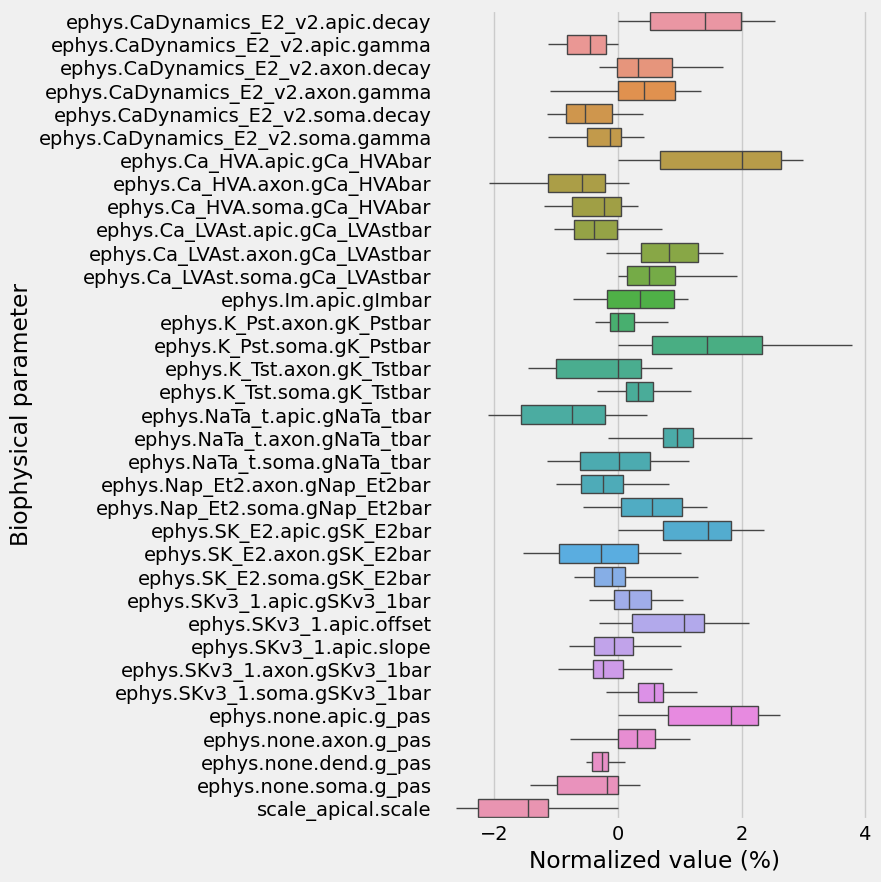

In [ ]:
I.plt.figure(figsize=(5, 10))

ax = I.sns.boxplot(
    data=d,
    y='Biophysical parameter', x='Normalized value (%)',
    whis=100,
    linewidth=1,
    showcaps = False
   )

In [ ]:
delayeds = [I.dask.delayed(
    simulator.run)(p, 'BAC') for _, p in explored_models[biophysical_parameter_names].iterrows()]
f = I.get_client().compute(delayeds)

In [ ]:
responses = [f_.result() for f_ in f]
BAC_responses = [response['BAC.hay_measure'] for response in responses]